In [1]:
import numpy as np 
import pandas as pd 
import os 
import sys 
import plotly.graph_objects as go 
import re

In [2]:
OR_LEARNING_PATH = os.path.join(os.getcwd().split('OR_learning')[0], 'OR_learning/')
sys.path.insert(0, os.path.join(OR_LEARNING_PATH, 'utils/'))

import voxel_functions as vf
import color_function as cf 
import plot_functions as pf 
import BindingCavity_functions as bc 
import SequenceAlignment_functions as sa

In [3]:
import importlib 

importlib.reload(bc)
importlib.reload(vf)
importlib.reload(pf)
importlib.reload(sa)

<module 'SequenceAlignment_functions' from '/mnt/data2/Justice/OR_learning/utils/SequenceAlignment_functions.py'>

### Structural Sequence Alignment
Use 3D superimposed structure to obtain aa alignment. \
Extract the aa aligned with conserved residue 

In [ ]:
"""
Following generates overall sequence alignement inferrence from structural alignment. 

Run via bc_SeqAlignment_dump.py for structural MSA of all pdbs
"""

AF2_PATH = '/mnt/data2/Justice/AF_files/AF_tmaligned_pdb/'
pdb_files = os.listdir(AF2_PATH)

reference_pdb = os.path.join(AF2_PATH, "Or51E2_Mol2.3_Olfr78_Psgr_tmaligned.pdb")
aligned_pdbs = [os.path.join(AF2_PATH, _pdb) for _pdb in pdb_files[20:30]]

aligned_pdbs.append(reference_pdb)
aligned_pairs = sa.generate_sequence_alignment_pairs_fromPDB(
    reference_pdb,
    aligned_pdbs,
    load_pdb_fn=bc.load_pdb_coordinates,  # Replace with your PDB-loading function
    gap_penalty=5
)

alignment = sa.union_gaps_with_consistency(aligned_pairs)

# for i in alignment.values(): 
#     print(i)

In [ ]:
alignment = pd.read_pickle('../../files/binding_cavity/dict_SeqAlignment_Full.pkl')

In [ ]:
"""
Plotting weblogo for all receptors 
"""

# Trimming alignment sequences to reduce highly gapped region
filtered_alignment, frequency_matrix = sa.trim_alignment(alignment, gap_threshold=0.5)
aligned_sequence = alignment['Or51E2']
filtered_sequence = ''.join(filtered_alignment[list(alignment.keys()).index('Or51E2')])

# Assigning residue highlights 
# highlight_positions = ["H104", "F155", "L158", "H180", "Q181", "N194", "G198", "L199", "A201", "I202", "S258", "R262"]
target_residues = ["L72", "I103", "H104", "A105", "S107", "A108", "S111", "F154", "F155", "L158", "V179", "H180", 
                       "Q181", "N194", "G198", "L199", "A201", "I202", "V205", "M206", "F250", "L254", "I255", "S258", 
                       "R262", "Y279"]
highlighted_mapping = sa.map_residues_to_filtered(aligned_sequence, 
                            filtered_sequence, 
                            target_residues)

bw_positions = ["N41", "D69", "R121", "V149", "C178", "D209", "P253", "P288"]
bw_mapping = sa.map_residues_to_filtered(aligned_sequence, 
                            filtered_sequence, 
                            bw_positions)
bw_mapping = {['1.50', '2.50', '3.50', '4.50', '45.50', '5.50', '6.50', '7.50'][i]: bw_mapping[_pos] for i, _pos in enumerate(bw_mapping)} #Rename index as BW labels 


# Plotting weblogo 
fig = pf.plot_weblogo(frequency_matrix, 
                      highlight_index=highlighted_mapping, 
                      bw_index=bw_mapping, 
                      figsize=[15,4],
                      row_length=30,
                      plot_title='All ORs structural sequence alignment (Gold consOR binding residue, sequence based on OR51E2)')
fig.savefig('../../output/Canonical_bc/SeqAlignment/SeqAlignment_Full.png')


In [17]:
Olfr_DL = pd.read_csv(os.path.join(OR_LEARNING_PATH, 'files/Olfr_DL.csv'), index_col=0)
Olfr_DL = dict(zip(Olfr_DL.Olfr, Olfr_DL.DL_OR))

#### SeqAlignment separated Class I and Class II 

In [ ]:
"""
Following generates overall sequence alignement inferrence from structural alignment. 

Run via bc_SeqAlignment_dump.py for structural MSA of all pdbs
"""

import pickle 
from tqdm import tqdm 

AF2_PATH = '/mnt/data2/Justice/AF_files/AF_tmaligned_pdb/'
pdb_files = os.listdir(AF2_PATH)

pdb_OR = [Olfr_DL.get(_pdb.split('_')[0], 'None') for _pdb in pdb_files]
pdb_OR = [re.match(r'Or(\d+)', _OR).group(1) if re.match(r'Or(\d+)', _OR) is not None else 'None' for _OR in pdb_OR ]

# Create index for Class I and Class II 
Class_I_idx = [i for i, _OR in enumerate(pdb_OR) if _OR in list(map(str, range(51,57)))]
Class_II_idx = [i for i, _OR in enumerate(pdb_OR) if _OR in list(map(str, range(1,15)))]


for i, _OR_class in enumerate([Class_I_idx, Class_II_idx]): 
    
    # Ref OR51E2 for Class I, Or1Ad1 for Class II 
    if i == 0: 
        reference_pdb = os.path.join(AF2_PATH, "Or51E2_Mol2.3_Olfr78_Psgr_tmaligned.pdb")
    else: 
        reference_pdb = os.path.join(AF2_PATH, "Olfr1377_tmaligned.pdb"
                                     )
    aligned_pdbs = [os.path.join(AF2_PATH, _pdb) for _pdb in [pdb_files[_idx] for _idx in _OR_class]]
    aligned_pdbs.append(reference_pdb)
    aligned_pairs = bc.generate_sequence_alignment_pairs_fromPDB(
        reference_pdb,
        tqdm(aligned_pdbs),
        load_pdb_fn=bc.load_pdb_coordinates,  # Replace with your PDB-loading function
        gap_penalty=5
    )

    alignment = bc.union_gaps_with_consistency(aligned_pairs)
     
    with open(os.path.join(OR_LEARNING_PATH, f'files/binding_cavity/dict_SeqAlignment_{['ClassI', 'ClassII'][i]}.pkl'), 'wb') as f:
        pickle.dump(alignment, f)


100%|██████████| 960/960 [19:11<00:00,  1.20s/it]


In [ ]:
"""
Plotting for Class I / Class II separately 
"""


for _OR_class in ['ClassI', 'ClassII']:
    alignment = pd.read_pickle(f'../../files/binding_cavity/dict_bc_SeqAlignment_{_OR_class}.pkl')# Define gap threshold (e.g., 90% gaps)

    filtered_alignment, frequency_matrix = pf.trim_alignment(alignment, gap_threshold=0.9)
    # aligned_sequences = [_seq[100:200] for _seq in alignment.values()]

    # primary_sequence = ''.join(filtered_alignment[1048]).replace('-','')
    # aligned_sequence = ''.join(filtered_alignment[1048])  # The aligned sequence
    # # highlight_positions = ["H104", "F155", "L158", "H180", "Q181", "N194", "G198", "L199", "A201", "I202", "S258", "R262"]
    # highlight_positions = ["L72", "I103", "H104", "A105", "S107", "A108", "S111", "F154", "F155", "L158", "V179", "H180", 
    #                     "Q181", "N194", "G198", "L199", "A201", "I202", "V205", "M206", "F250", "L254", "I255", "S258", 
    #                     "R262", "Y279"]
    # bw_positions = ["N41", "D69", "R121", "V149", "C178", "D209", "P253", "P288"]

    # highlighted_mapping = pf.map_highlight_positions(primary_sequence, aligned_sequence, highlight_positions, verify_aa=False)
    # bw_mapping = pf.map_highlight_positions(primary_sequence, aligned_sequence, bw_positions)
    # bw_mapping = {['1.50', '2.50', '3.50', '4.50', '45.50', '5.50', '6.50', '7.50'][i]: bw_mapping[_pos] for i, _pos in enumerate(bw_mapping)} #Rename index as BW labels 

    fig = pf.plot_weblogo(frequency_matrix, 
                        # highlight_index=highlighted_mapping, 
                        # bw_index=bw_mapping, 
                        figsize=[20,4],
                        row_length=30,
                        plot_title=f'{_OR_class} ORs structural sequence alignment')
    # fig.savefig(f'../../output/Canonical_bc/SeqAlignment/SeqAlignment_{_OR_class}.png')

### Cbc Structural Sequence Alignment

In [108]:
Cbc_coords = pd.read_pickle(os.path.join(OR_LEARNING_PATH, 'files/binding_cavity/canonical_bc_coords.pkl'))
Cbc_res_coords = pd.read_pickle(os.path.join(OR_LEARNING_PATH, 'files/binding_cavity/dict_Cbc_res_coords.pkl'))


In [ ]:
"""
Align Cbc residues 
"""
# TEST_OR = ['Or51E2', 'Or6C1', 'Or5P50', 'Or5W10']

ref = np.array(sorted(Cbc_res_coords['Or51E2'][Cbc_res_coords['Or51E2'].T[2] == 'CA'], key=lambda x: int(x[0])))
ref_backbone = ref.T[3:6].T.astype(float)

tgt = [np.array(sorted(Cbc_res_coords[_OR][Cbc_res_coords[_OR].T[2] == 'CA'], key=lambda x: int(x[0]))) for _OR in Cbc_res_coords]
tgt_backbone = [_tgt_coords.T[3:6].T.astype(float) for _tgt_coords in tgt]

ref_residues = ref.T[1]
ref_sequence = "".join([sa.AA_THREE_TO_ONE.get(_residue, 'X') for _residue in ref_residues])
tgt_residues = [_tgt_coords.T[1] for _tgt_coords in tgt]


Cbc_aligned_pairs = {}
for i, _OR in enumerate(Cbc_res_coords): 
    tgt_sequence = "".join([sa.AA_THREE_TO_ONE.get(_residue, 'X') for _residue in tgt_residues[i]])
    Cbc_aligned_pairs[_OR] = sa.structural_alignment_dp(
        ref_backbone, ref_sequence, tgt_backbone[i], tgt_sequence, gap_penalty=10
    )
    
# for i, _val in enumerate(alignment.values()): 
#     print(f'{_val[1]}     {TEST_OR[i]}')
    
Cbc_alignment = sa.union_gaps_with_consistency(Cbc_aligned_pairs)

# import pickle 
# with open(os.path.join(OR_LEARNING_PATH, 'files/binding_cavity/dict_SeqAlignment_Cbc.pkl'), 'wb') as f:
#     pickle.dump(Cbc_alignment, f)


In [ ]:
Cbc_alignment = pd.read_pickle(os.path.join(OR_LEARNING_PATH,'files/binding_cavity/dict_SeqAlignment_Cbc.pkl'))

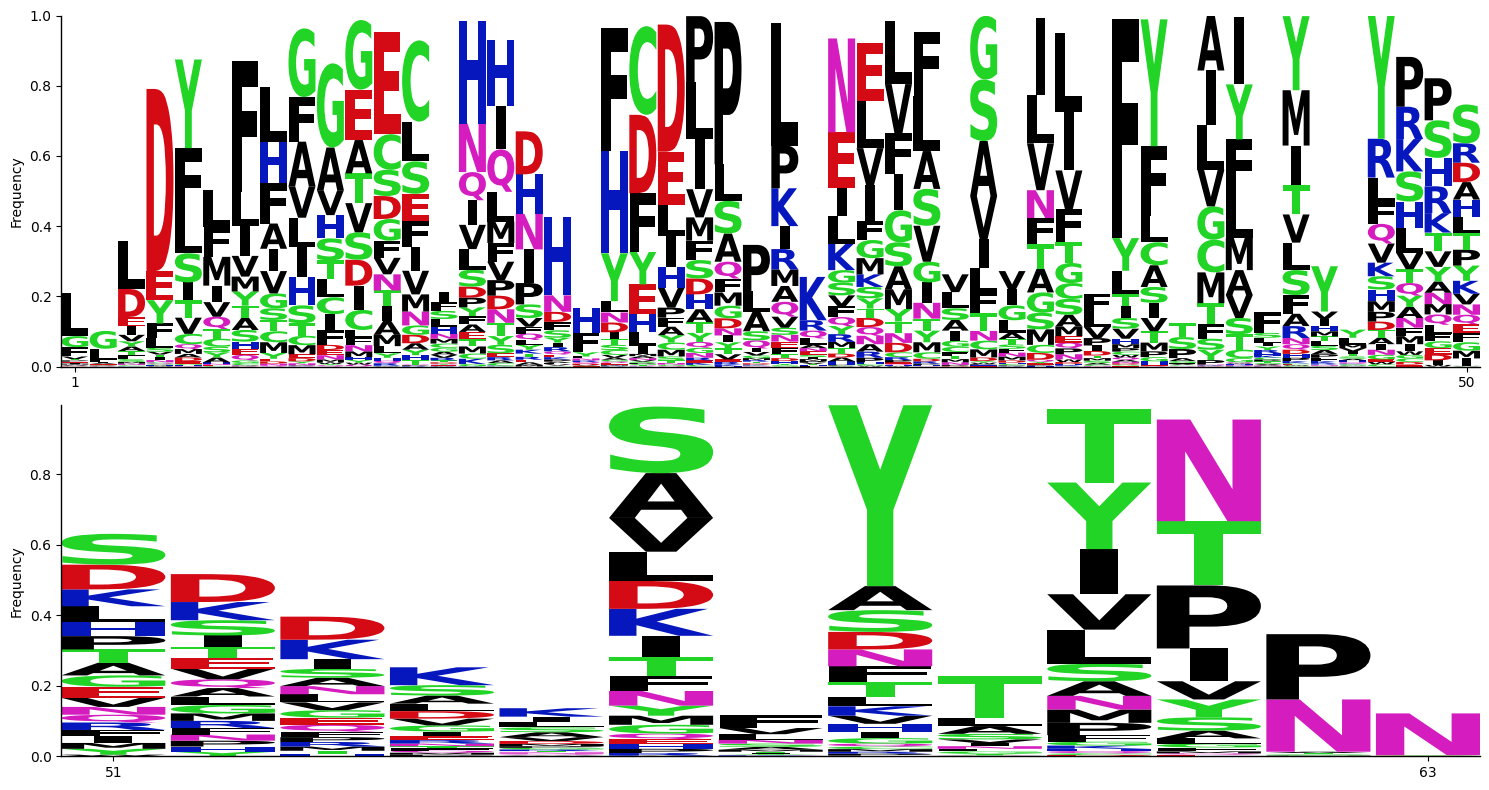

In [114]:
import matplotlib.pyplot as plt
import logomaker 


# Define gap threshold (e.g., 90% gaps)
filtered_alignment, frequency_matrix = sa.trim_alignment(Cbc_alignment, gap_threshold=0.9)

primary_sequence = ''.join(filtered_alignment[1048]).replace('-','')
aligned_sequence = ''.join(filtered_alignment[1048])  # The aligned sequence
# highlight_positions = ["H104", "F155", "L158", "H180", "Q181", "N194", "G198", "L199", "A201", "I202", "S258", "R262"]
# bw_positions = ["N41", "D69", "R121", "V149", "C178", "D209", "P253", "P288"]

# highlighted_mapping = pf.map_highlight_positions(primary_sequence, aligned_sequence, highlight_positions)
bw_mapping = sa.map_highlight_positions(primary_sequence, aligned_sequence, bw_positions, verify_aa=False)
bw_mapping = {['1.50', '2.50', '3.50', '4.50', '45.50', '5.50', '6.50', '7.50'][i]: bw_mapping[_pos] for i, _pos in enumerate(bw_mapping)} #Rename index as BW labels 

fig = pf.plot_weblogo(frequency_matrix, 
                    #   highlight_index=highlighted_mapping, 
                    #   bw_index=bw_mapping, 
                      figsize=[15,4],
                      row_length=50)
# fig.savefig('../../output/Canonical_bc/SeqAlignment/SeqAlignment_Cbc.png')

### Odorant Binding Residue Structural Sequence Alignment 

In [4]:
# Making Grantham MDS dataframe
Olfr_DL = np.load('../../files/Olfr_DL.npy', allow_pickle=True).item()

alignment = pd.read_pickle(os.path.join(OR_LEARNING_PATH, 'files/binding_cavity/dict_bc_SeqAlignment_Full.pkl'))
alignment = {Olfr_DL.get(_OR, _OR):alignment[_OR] for _OR in list(alignment.keys())}
alignment = { _OR: alignment[_OR] for _OR in np.sort(list(alignment.keys()))}


⚠️ Warning: Residue A105 was removed after filtering (AA mismatch).


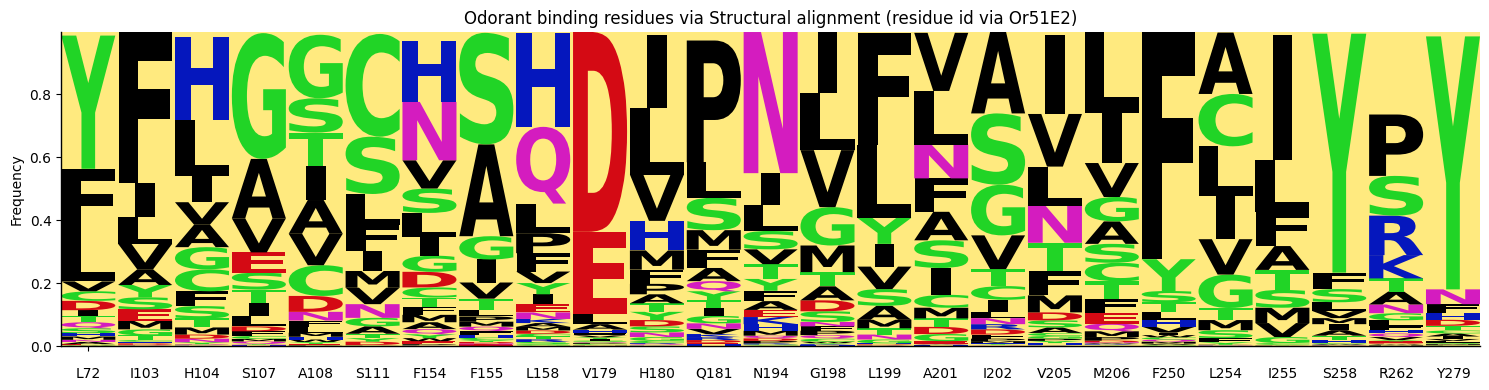

In [ ]:
# Trimming alignment sequences to reduce highly gapped region
filtered_alignment, frequency_matrix = sa.trim_alignment(alignment, gap_threshold=0.5)
aligned_sequence = alignment['Or51E2']
filtered_sequence = ''.join(filtered_alignment[list(alignment.keys()).index('Or51E2')])

# Assigning residue highlights 
target_residues = ["L72", "I103", "H104", "A105", "S107", "A108", "S111", "F154", "F155", "L158", "V179", "H180", 
                       "Q181", "N194", "G198", "L199", "A201", "I202", "V205", "M206", "F250", "L254", "I255", "S258", 
                       "R262", "Y279"]
highlighted_mapping = sa.map_residues_to_filtered(aligned_sequence, 
                            filtered_sequence, 
                            target_residues)

# Extract updated target_residue positions to filtered positions then filter matrix by target_residues 
highlighted_mapping_pos = [highlighted_mapping[_res]-1 for _res in highlighted_mapping]
filtered_alignment = filtered_alignment[:, highlighted_mapping_pos]
frequency_matrix = frequency_matrix[:, highlighted_mapping_pos]

# Plotting weblogo 
fig = pf.plot_weblogo(frequency_matrix, 
                      highlight_index={_res: i+1 for i, _res in enumerate(highlighted_mapping)}, 
                      highlight_text_color="black", 
                      highlight_text_size=12, 
                    #   bw_index=bw_mapping, 
                      figsize=[15,4],
                      row_length=30,
                      plot_title='Odorant binding residues via Structural alignment (residue id via Or51E2)', 
                      show_axticks=False)

fig.savefig('../../output/Canonical_bc/SeqAlignment/SeqAlignment_Obr.png')

In [ ]:
# Save Odorant Binding Residue alignment as pickle 

OBR_alignment = { _key: ''.join(filtered_alignment[i]) for i, _key in enumerate(alignment.keys())}

import pickle 
with open(os.path.join(OR_LEARNING_PATH, 'files/binding_cavity/dict_SeqAlignment_OBR.pkl'), 'wb') as f:
    pickle.dump(Cbc_alignment, f)


In [45]:
import importlib 

importlib.reload(bc)
importlib.reload(vf)
importlib.reload(pf)
importlib.reload(sa)

<module 'SequenceAlignment_functions' from '/mnt/data2/Justice/OR_learning/utils/SequenceAlignment_functions.py'>